In [4]:
#Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [5]:
#Get data 

cwd = os.path.normpath(os.path.dirname(os.path.dirname(os.getcwd())))
df = pd.read_csv(cwd+'/data/Final_Energy_dataset.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)

# Filter for the first 30 'load' and 'pv' columns using list comprehension
columns_to_keep = [
    col for col in df.columns 
    if (col.startswith('load_') or col.startswith('pv_')) and int(col.split('_')[1]) <= 30
]
filtered_df = df[columns_to_keep]

# Calculate prosumption for each user
prosumption_df = pd.DataFrame(index=df.index)
for i in range(1, 31):  # Assuming 30 users
    load_col = f'load_{i}'
    pv_col = f'pv_{i}'
    if load_col in filtered_df.columns and pv_col in filtered_df.columns:
        prosumption_df[f'prosumption_{i}'] = filtered_df[pv_col] - filtered_df[load_col]

#Only keep month 3,7,11 of the data to limit computational time
#prosumption_df = prosumption_df[prosumption_df.index.month.isin([3, 7, 11])]
#prosumption_df = prosumption_df[prosumption_df.index.day.isin([1,2,3,4,5,6,7,8,9,10])]

prosumption_df.head(1)

,prosumption_1,prosumption_2,prosumption_3,prosumption_4,prosumption_5,prosumption_6,prosumption_7,prosumption_8,prosumption_9,prosumption_10,...,prosumption_21,prosumption_22,prosumption_23,prosumption_24,prosumption_25,prosumption_26,prosumption_27,prosumption_28,prosumption_29,prosumption_30
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-01 00:30:00,-1.553,-0.085,-2.698,-0.075,-1.917,-0.044,-1.831,-0.124,-0.033,-0.031,...,-0.896,-0.072,-0.111,-0.146,-0.1,-0.375,-0.265,-0.1,-0.103,-2.461


# 1. Distribution statistics for clustering

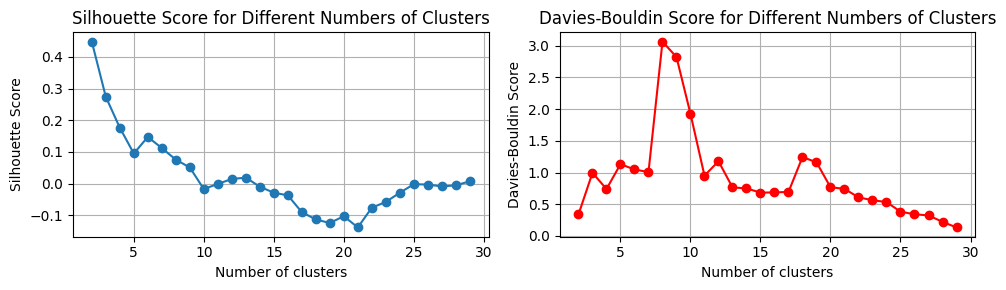

Prosumption Statistics and Clustering (showing first few rows):


,mean,std,skew,kurtosis,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,...,cluster_20,cluster_21,cluster_22,cluster_23,cluster_24,cluster_25,cluster_26,cluster_27,cluster_28,cluster_29
prosumption_1,-0.175367,0.743564,-0.080115,0.117901,0,1,1,1,2,6,...,13,14,12,20,9,2,15,12,2,25
prosumption_2,-0.324771,0.622262,-2.238914,6.098175,0,2,0,4,1,4,...,3,7,2,3,7,5,2,2,9,27


In [6]:
# Calculate basic statistics
stats_df = pd.DataFrame(index=prosumption_df.columns)

stats_df['mean'] = prosumption_df.mean() # Central tendency
stats_df['std'] = prosumption_df.std() # Variability
stats_df['skew'] = prosumption_df.apply(skew) # asymmetry of the distribution (shape)
stats_df['kurtosis'] = prosumption_df.apply(kurtosis) #"tailedness" of the distribution (shape).

silhouette_scores = []
davies_bouldin_scores = []
all_clusters = {}

for n_clusters in range(2, 30):  # Clustering with sizes from 2 to 30
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(stats_df)
    stats_df[f'cluster_{n_clusters}'] = clusters
    silhouette_avg = silhouette_score(stats_df.iloc[:, :-n_clusters], clusters)
    davies_bouldin_avg = davies_bouldin_score(stats_df.iloc[:, :-n_clusters], clusters)
    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin_avg)
    all_clusters[n_clusters] = clusters

# Plot the silhouette scores for evaluation
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(range(2, 30), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(2, 30), davies_bouldin_scores, marker='o', color='r')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score for Different Numbers of Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()

# Display the results for clusters
print("Prosumption Statistics and Clustering (showing first few rows):")
display(stats_df.head(2))

# Save clusters and silhouette scores for further analysis
#clusters_df = pd.DataFrame(all_clusters)
#clusters_df.to_csv('clusters.csv')
#silhouette_scores_df = pd.DataFrame(silhouette_scores, index=range(2, 31), columns=['Silhouette Score'])
#silhouette_scores_df.to_csv('silhouette_scores.csv')

# 2. Histogram based clustering

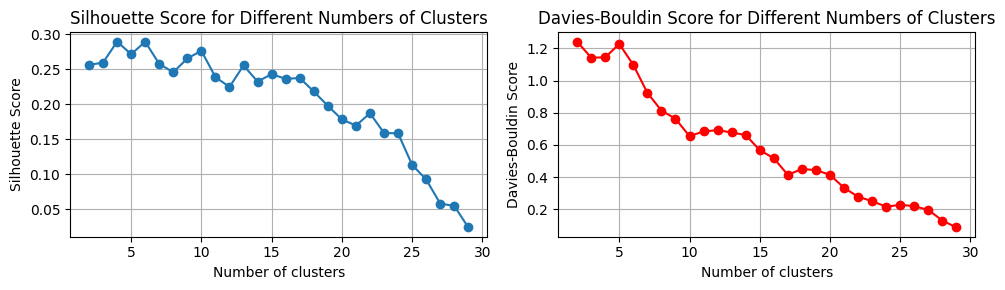

In [13]:
# Number of bins for histograms
num_bins = 30
num_clusters=30

# Generate histograms for each prosumption time series
hist_features = []
for col in prosumption_df.columns:
    hist, bin_edges = np.histogram(prosumption_df[col], bins=num_bins, density=True)
    hist_features.append(hist)

# Create a dataframe for histogram features
hist_features_df = pd.DataFrame(hist_features, columns=[f'bin_{i}' for i in range(num_bins)])


# Plot the silhouette scores for different numbers of clusters (example)
silhouette_scores = []
davies_bouldin_scores = []
all_clusters = {}

for n_clusters in range(2, num_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(hist_features_df)
    silhouette_avg = silhouette_score(hist_features_df, clusters)
    davies_bouldin_avg = davies_bouldin_score(hist_features_df, clusters)
    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin_avg)
    all_clusters[n_clusters] = clusters

# Plot the scores
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(range(2, num_clusters), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(2, num_clusters), davies_bouldin_scores, marker='o', color='r')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score for Different Numbers of Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()

# Probability Density Function for Clustering

In [15]:
from scipy.stats import gaussian_kde

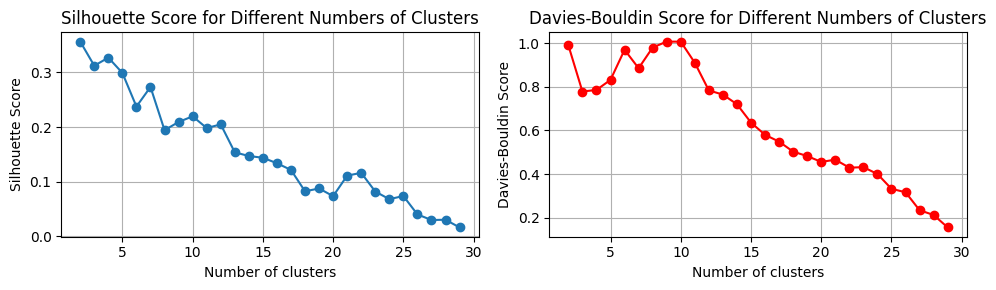

In [19]:
# Points at which to evaluate the PDFs

# Determine the minimum and maximum values across all time series
data_min = prosumption_df.min().min()
data_max = prosumption_df.max().max()

x_vals = np.linspace(data_min, data_max, 100)

# Generate PDFs for each prosumption time series
pdf_features = []
for col in prosumption_df.columns:
    kde = gaussian_kde(prosumption_df[col])
    pdf = kde(x_vals)
    pdf_features.append(pdf)

# Create a dataframe for PDF features
pdf_features_df = pd.DataFrame(pdf_features, columns=[f'pdf_{i}' for i in range(len(x_vals))])

# Plot the silhouette scores for different numbers of clusters (example)
silhouette_scores = []
davies_bouldin_scores = []

for n_clusters in range(2, num_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(pdf_features_df)
    silhouette_avg = silhouette_score(pdf_features_df, clusters)
    davies_bouldin_avg = davies_bouldin_score(pdf_features_df, clusters)
    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin_avg)

# Plot the scores
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(range(2, num_clusters), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(2, num_clusters), davies_bouldin_scores, marker='o', color='r')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score for Different Numbers of Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()

# 2. Combined Clustering

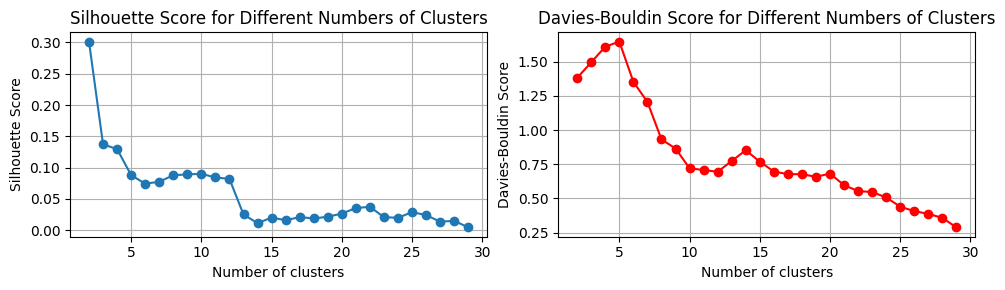

In [31]:
# Resample the DataFrame to monthly frequency and calculate sum, min, max, and std for each household

#daily_stats = prosumption_df.resample('D').agg(['sum', 'min', 'max', 'std'])
monthly_stats = prosumption_df.resample('M').agg(['sum', 'min', 'max', 'std'])

# Flatten the MultiIndex columns
monthly_stats.columns = ['_'.join(col) for col in monthly_stats.columns]

# Add a column for the month to pivot correctly
monthly_stats['Month'] = monthly_stats.index

# Pivot the DataFrame to get a row per building and columns for each month's statistics
monthly_stats_pivot = monthly_stats.melt(id_vars='Month', var_name='Building_Stat', value_name='Value')
monthly_stats_pivot[['Building', 'Stat']] = monthly_stats_pivot['Building_Stat'].str.rsplit('_', n=1, expand=True)
monthly_stats_pivot = monthly_stats_pivot.pivot_table(index='Building', columns=['Month', 'Stat'], values='Value')

# Flatten the pivot table columns
monthly_stats_pivot.columns = ['_'.join(map(str, col)).strip() for col in monthly_stats_pivot.columns]

# Drop rows with any missing values (optional, depending on how you want to handle them)
monthly_stats_pivot.dropna(inplace=True)


silhouette_scores = []
davies_bouldin_scores = []

for n_clusters in range(2, num_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(monthly_stats_pivot)
    silhouette_avg = silhouette_score(monthly_stats_pivot, clusters)
    davies_bouldin_avg = davies_bouldin_score(monthly_stats_pivot, clusters)
    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin_avg)

# Plot the scores
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.plot(range(2, num_clusters), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(2, num_clusters), davies_bouldin_scores, marker='o', color='r')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score for Different Numbers of Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()

# 4. Distribution Visualizations

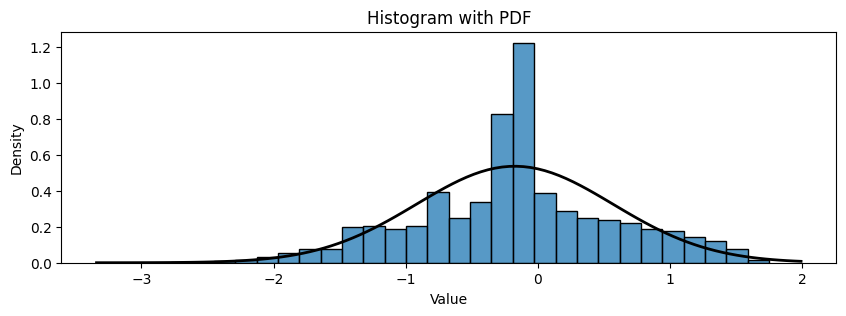

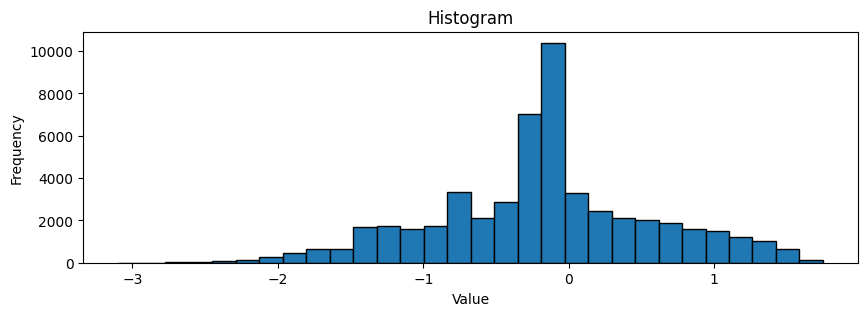

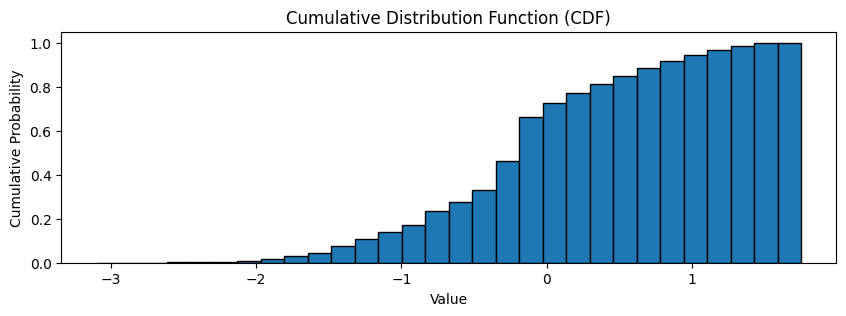

C:\Users\rs1044\AppData\Local\Temp\ipykernel_35240\4022149981.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)


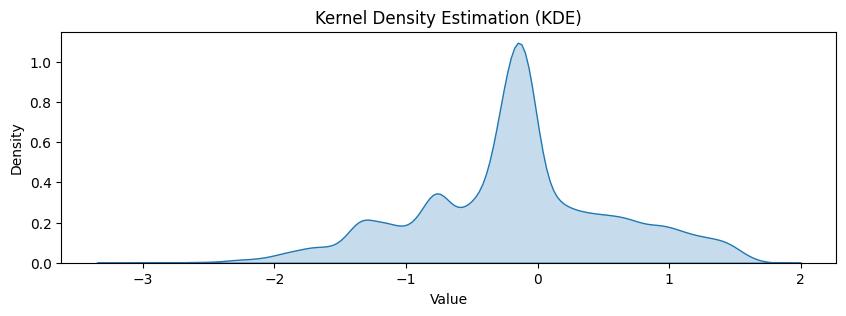

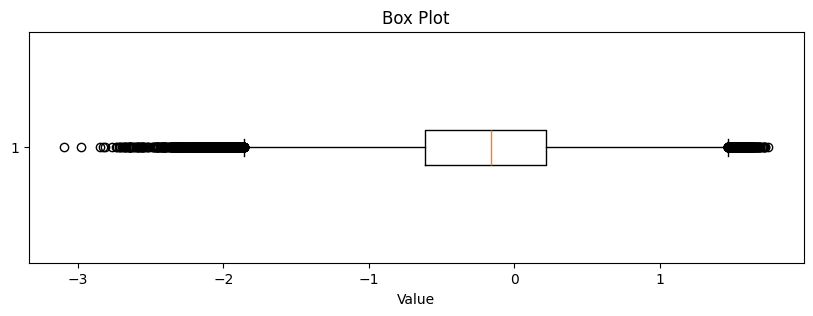

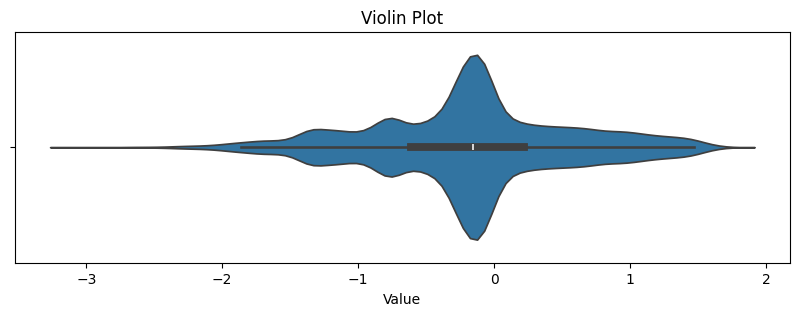

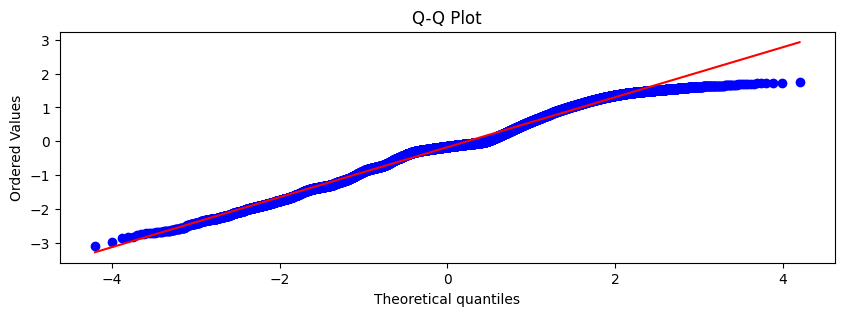

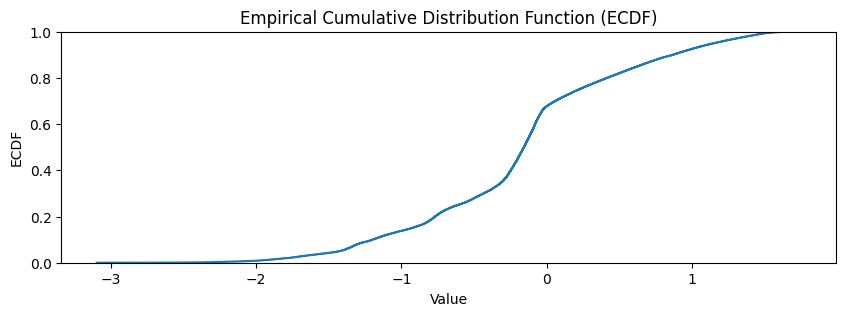

C:\Users\rs1044\AppData\Local\Temp\ipykernel_35240\4022149981.py:79: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)


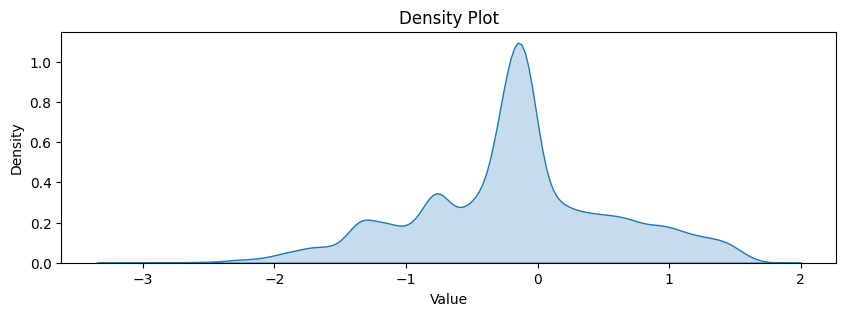

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot

# Sample data
data = prosumption_df["prosumption_1"]  # Replace with your time series data

# 1. Probability Density Function (PDF)
plt.figure(figsize=(10, 3))
sns.histplot(data, kde=False, stat='density', bins=30)
plt.title('Histogram with PDF')
plt.xlabel('Value')
plt.ylabel('Density')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(data), np.std(data))
plt.plot(x, p, 'k', linewidth=2)
plt.show()

# 2. Histogram
plt.figure(figsize=(10, 3))
plt.hist(data, bins=30, edgecolor='k')
plt.title('Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# 3. Cumulative Distribution Function (CDF)
plt.figure(figsize=(10, 3))
plt.hist(data, bins=30, cumulative=True, edgecolor='k', density=True)
plt.title('Cumulative Distribution Function (CDF)')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.show()

# 4. Kernel Density Estimation (KDE)
plt.figure(figsize=(10, 3))
sns.kdeplot(data, shade=True)
plt.title('Kernel Density Estimation (KDE)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# 5. Box Plot
plt.figure(figsize=(10, 3))
plt.boxplot(data, vert=False)
plt.title('Box Plot')
plt.xlabel('Value')
plt.show()

# 6. Violin Plot
plt.figure(figsize=(10, 3))
sns.violinplot(data, orient='h')
plt.title('Violin Plot')
plt.xlabel('Value')
plt.show()

# 7. Q-Q Plot
plt.figure(figsize=(10, 3))
probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# 8. P-P Plot
# Not directly supported in many libraries, but similar to Q-Q Plot

# 9. Empirical Cumulative Distribution Function (ECDF)
plt.figure(figsize=(10, 3))
sns.ecdfplot(data)
plt.title('Empirical Cumulative Distribution Function (ECDF)')
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.show()

# 10. Density Plot
plt.figure(figsize=(10, 3))
sns.kdeplot(data, shade=True)
plt.title('Density Plot')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


In [5]:
# Calculate basic statistics
stats_df = pd.DataFrame(index=prosumption_df.columns)

stats_df['mean'] = prosumption_df.mean()
stats_df['std'] = prosumption_df.std()
stats_df['skew'] = prosumption_df.apply(skew)
stats_df['kurtosis'] = prosumption_df.apply(kurtosis)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(stats_df)

stats_df['cluster'] = clusters

# Calculate silhouette score to evaluate clustering
silhouette_avg = silhouette_score(stats_df.iloc[:, :-1], clusters)

# Display the results
print("Prosumption Statistics and Clustering")
display(stats_df.head(2))

# Output silhouette score
print(f"Silhouette Score: {silhouette_avg}")

,mean,std,skew,kurtosis
prosumption_1,-0.175367,0.743564,-0.080115,0.117901
prosumption_2,-0.324771,0.622262,-2.238914,6.098175


Mean: -0.17536684534671534
Standard Deviation: 0.7435640721309728
Skewness: -0.0801148629488048
Kurtosis: 0.11790095674924661


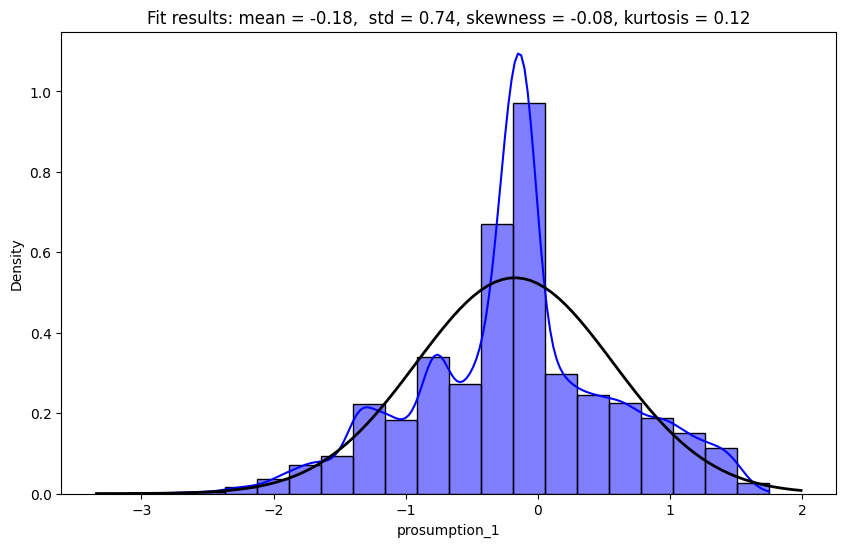

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, norm
import matplotlib.pyplot as plt
import seaborn as sns

# Select the specific prosumption series
prosumption_series = prosumption_df['prosumption_1']

# Calculate basic statistics
mean = prosumption_series.mean()
std_dev = prosumption_series.std()
skewness = skew(prosumption_series)
kurt = kurtosis(prosumption_series)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std_dev}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(prosumption_series, bins=20, kde=True, color='blue', stat="density")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2)
title = f"Fit results: mean = {mean:.2f},  std = {std_dev:.2f}, skewness = {skewness:.2f}, kurtosis = {kurt:.2f}"
plt.title(title)
plt.show()